# Автор: Серегин М.С

In [351]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import tqdm
from torch import nn
import time

# Анализ и предобработка данных

In [2]:
df = pd.read_csv("ratings.csv")

In [ ]:
df.head()

**Заменим user_uid на индексы с 0 до числа пользователей, element_uid - от 0 до числа элементов**

In [5]:
replace_users = dict(zip(df.user_uid.unique(), np.arange(104563)))

In [6]:
replace_items = dict(zip(df.element_uid.unique(), np.arange(7519)))

In [7]:
df["user_id"] = df.user_uid.apply(lambda x: replace_users[x])

In [8]:
df["item_id"] = df.element_uid.apply(lambda x:replace_items[x])

In [9]:
df = df.drop(["user_uid", "element_uid"], axis=1)

In [10]:
q_users, q_items = max(df.user_id)+1, max(df.item_id)+1
max(df.user_id)+1, max(df.item_id)+1 # столько уникальных пользователей и предметов

(104563, 7519)

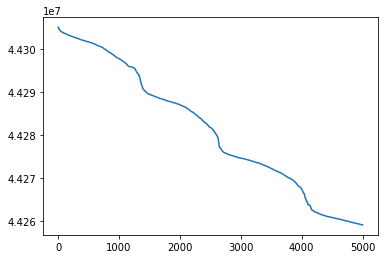

In [11]:
plt.plot(df.ts[:5000])# таблица уже отсортирована по времени

Самые последние оценки находятся в начале. **Для валидации используем последние оценки, чтобы "не заглядывать в будущее".**

Посмотрим распределение количества оцененных фильмов  пользователями. 

In [12]:
seri = df.groupby("user_id").count()["item_id"]

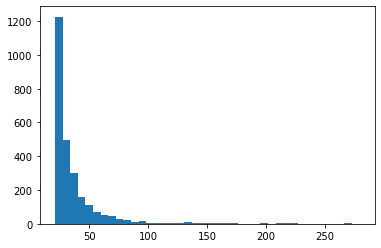

In [13]:
plt.figure(figsize=(12,12))
_ = plt.hist(seri[(seri>20) & (seri<300)],40)

#### В валидацию добавим тройки (user,item,rating) тех пользователей, которые оценили хотя бы 60 фильмов. Добавлять будем 15% оцененных фильмов. 

In [14]:
seri[(seri>60)].sum() * 0.15 # примерная мощность данных валидации

4775.4

# Формируем валидационный датасет

In [15]:
val_df = pd.DataFrame([])
for user in tqdm.tqdm(replace_users.values()):
    tmp_df = df[df["user_id"] == user]
    if len(tmp_df)>60:
        paste_df = tmp_df.iloc[:int(np.ceil(0.15*len(tmp_df)))]
        val_df = pd.concat((val_df,paste_df))
        df.drop(paste_df.index,inplace=True)
        
        

100%|██████████| 104563/104563 [00:42<00:00, 2441.17it/s]


In [16]:
df.index = range(len(df.index))
val_df.index = range(len(val_df.index))

Итак, тренировочный и валидационный датасет построены.

(array([   831.,   1661.,   9231.,   4604.,  17161.,  15538.,  32533.,
         34756.,  89391., 228186.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

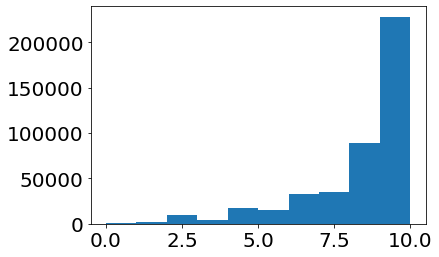

In [466]:
plt.hist(df.rating, 10)

# Построение CF

В нашем первичном исследовании будем оценивать качество трех/пяти-слойных моделей. Класс CF будет состоять из нескольких блоков (NNBlock), каждый из которых имплементирует линейный слой, функцию активации. В блоки впоследствии можно будет добавить различные модификации.

Гиперпараметры модели: 
1. Количество линейных слоев
2. Размер эмбеддинга, то есть количество латентных факторов у пользователя и предмета
3. Параметр, отвечающий за кратность увеличения количества нейронов в каждом последующем слое. По умолчанию равно 2, то есть в каждом следующем в два раза больше нейронов, чем предыдущем. 

В качестве метрики возьмем MSE, т.к. оптимизация не изменится, если взять RMSE. Для формирования ответа возьмем корень из MSE. 


In [247]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        rating, ts, user_id, item_id = self.df.iloc[idx].astype(np.int32)
        return [user_id,item_id], rating
    

In [248]:
class NNBlock(nn.Module):
    def __init__(self,in_features, out_features, fn_act=nn.ReLU):
        super().__init__()
        self.out_features = out_features
        self.linear1 = nn.Linear(in_features, out_features)
        self.act = fn_act()
        
    def forward(self,x):
        out = self.linear1(x)
        out = self.act(out)
        return out
        
        
        
        
        
        
        

In [249]:
class CF(nn.Module):
    def __init__(self,amount_layers=3,q_users=q_users,q_items=q_items,fn_act=nn.ReLU, latent_factors=8, base_multiply=2):
        super().__init__()
        self.q_users = q_users
        self.q_items = q_items
        # слои создают скрытые представления пользователя и предмета
        self.emb_user = nn.Linear(q_users, latent_factors)
        self.emb_item = nn.Linear(q_items, latent_factors)
        lt_f = latent_factors
        
        self.block1 = NNBlock(lt_f*2, lt_f*2*base_multiply,fn_act)
        self.block2 = NNBlock(self.block1.out_features, self.block1.out_features*base_multiply,fn_act)
        self.block3 = NNBlock(self.block2.out_features, self.block2.out_features*base_multiply,fn_act) if amount_layers > 3 else nn.Identity()
        self.block4 = NNBlock(self.block3.out_features, self.block3.out_features*base_multiply,fn_act) if amount_layers > 4 else nn.Identity()
        self.end_linear = nn.Linear(lt_f*2*(base_multiply**(amount_layers-1)),1)
        
        
        
    def forward(self,x):
        
        #формируем бинарные векторы для пользователя и предмета
        bt_size = len(x[0])
        us_bin = torch.zeros(bt_size,self.q_users)
        it_bin = torch.zeros(bt_size, self.q_items)
        us_bin[range(bt_size), x[0]] = 1
        it_bin[range(bt_size), x[1]] = 1
        
        # получаем эмбеддинги
        emb_us = self.emb_user(us_bin.float())
        emb_it = self.emb_item(it_bin.float())
        
        concat_vec = torch.concat((emb_us, emb_it),dim=1)
        
        out = self.block1(concat_vec)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.end_linear(out)
        
        return out

# Выбор функции активации

In [250]:
def perform_epoch(model, loader, criterion, 
                optimizer=None):
    is_train = optimizer is not None

    if is_train:  
        model.train()
    else:
        model.eval()

    total_loss = 0
    total_n = 0
    with EmptyContext() if is_train else torch.no_grad():
        for batch_data, batch_labels in (loader):
            model_labels = model(batch_data).view(-1).float()
 

            new_loss = criterion(model_labels, batch_labels.float())
            if is_train:
              optimizer.zero_grad()
              new_loss.backward()
              optimizer.step() 

            one_batch_loss = float(criterion(model_labels, batch_labels))

            
            total_loss += one_batch_loss
            total_n += 1 
    return total_loss / total_n 

In [253]:
class EmptyContext:
    def __enter__(self):
        pass
    
    def __exit__(self, *args):
        pass

In [255]:
train_dataset = Dataset(df)
val_dataset = Dataset(val_df)

train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=512)
val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=1024)

In [256]:
lst_activation = [nn.ReLU, nn.Sigmoid, nn.SELU, nn.GELU]
lst_name = ["ReLU", "Sigmoid", "SELU", "GELU"]
dct_first = {}
for i in range(len(lst_activation)):
    fn_act = lst_activation[i]
    name_act = lst_name[i]
    
    loss_fn = nn.MSELoss()
    model = CF(fn_act=fn_act)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    dct_first[name_act] = []
    for epoch in tqdm.tqdm(range(5)):
        train_loss = perform_epoch(model,train_dataloader,loss_fn,optimizer,)
        val_loss = perform_epoch(model,val_dataloader,loss_fn,None)
        dct_first[name_act].append([np.sqrt(train_loss), np.sqrt(val_loss)])


100%|██████████| 5/5 [10:00<00:00, 120.04s/it]


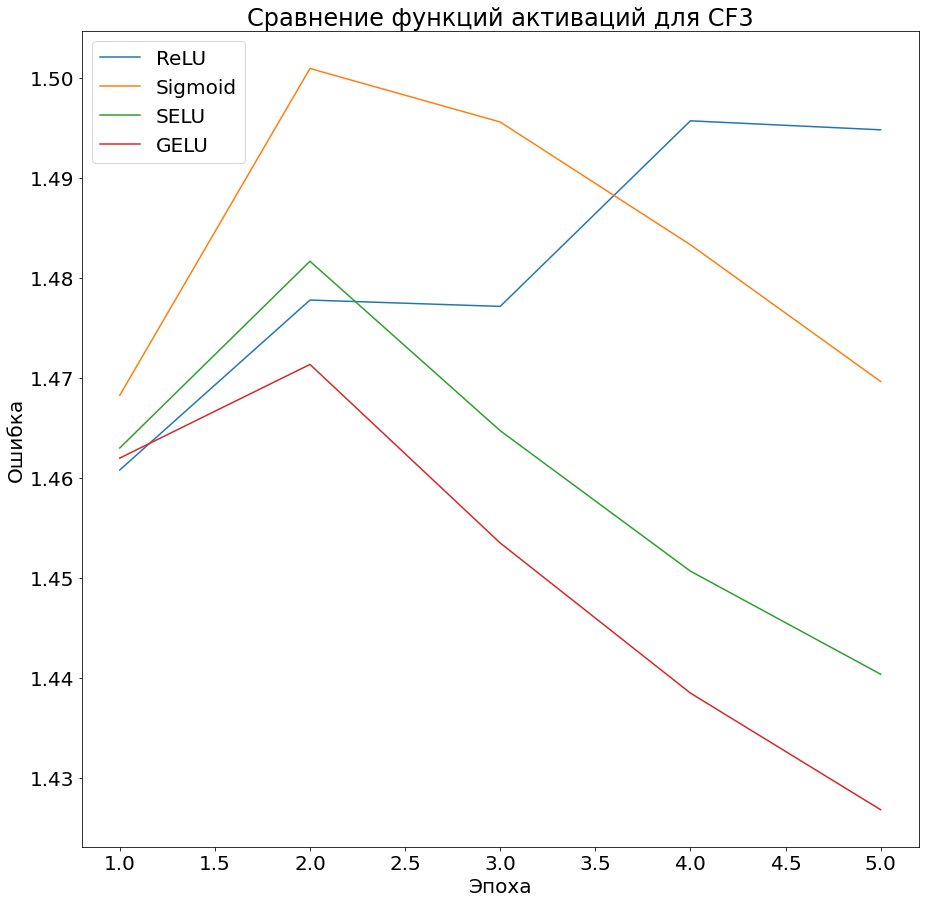

In [263]:
plt.figure(figsize=(15,15))
plt.rcParams["font.size"]= 20
for key in dct_first:
    arr = np.array(dct_first[key])
    ln = len(arr[:,0])
    plt.plot(range(1,ln+1),arr[0:,1], label=key)
    plt.legend()
    
plt.title("Сравнение функций активаций для CF3")
plt.xlabel("Эпоха")
_=plt.ylabel("Ошибка")

In [258]:
lst_activation = [nn.ReLU, nn.Sigmoid, nn.SELU, nn.GELU]
lst_name = ["ReLU", "Sigmoid", "SELU", "GELU"]
dct_second = {}
for i in range(len(lst_activation)):
    fn_act = lst_activation[i]
    name_act = lst_name[i]
    
    loss_fn = nn.MSELoss()
    model = CF(amount_layers=5,fn_act=fn_act)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    dct_second[name_act] = []
    for epoch in tqdm.tqdm(range(5)):
        train_loss = perform_epoch(model,train_dataloader,loss_fn,optimizer,)
        val_loss = perform_epoch(model,val_dataloader,loss_fn,None)
        dct_second[name_act].append([np.sqrt(train_loss), np.sqrt(val_loss)])  


100%|██████████| 5/5 [10:19<00:00, 123.88s/it]


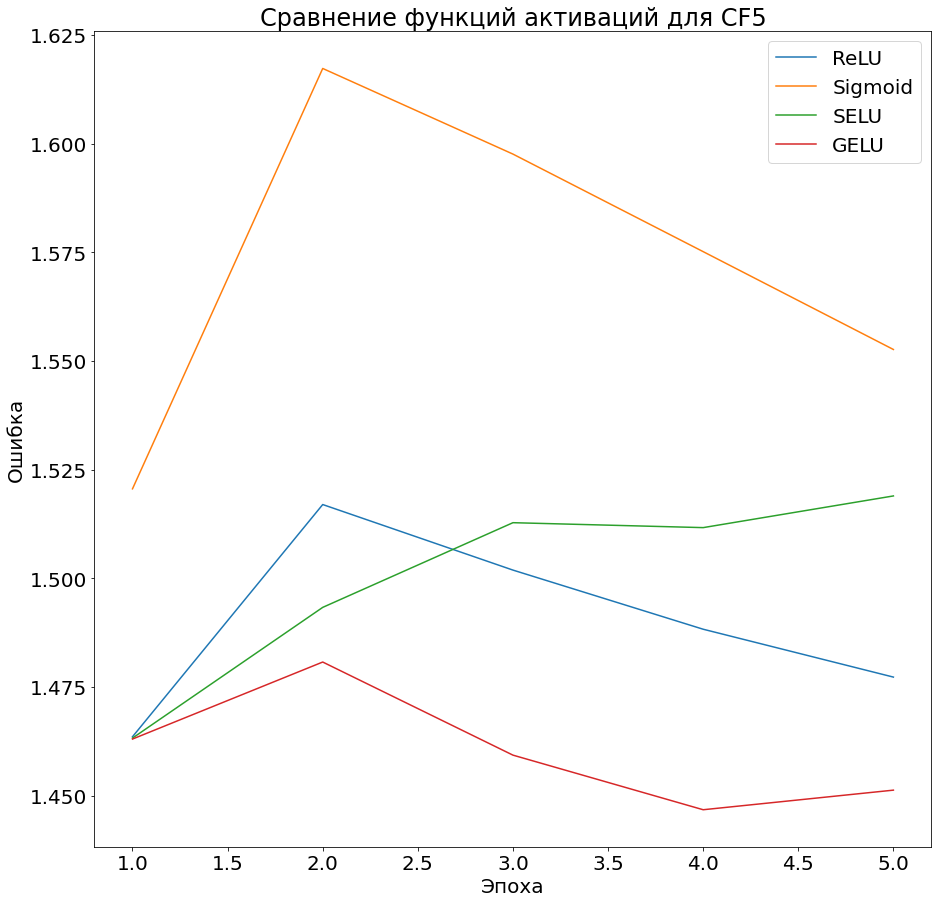

In [262]:
plt.figure(figsize=(15,15))
plt.rcParams["font.size"]= 20
for key in dct_second:
    arr = np.array(dct_second[key])
    ln = len(arr[:,0])
    plt.plot(range(1,ln+1),arr[:,1], label=key)
    plt.legend()
    
plt.title("Сравнение функций активаций для CF5")
plt.xlabel("Эпоха")
_ = plt.ylabel("Ошибка")

**Итак, для обеих моделей, GeLU - наилучшая функция активации. В дальнейшем будем ее использовать.**

# Оценка и сравнение моделей

**Запустим модели с выбранной функцией активации. Сравним качество на валидации и время работы алгоритмов.**

In [288]:
train_dataset = Dataset(df)
val_dataset = Dataset(val_df)

train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=512, shuffle=True, drop_last=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=512)

In [289]:
dct_loss = {}
dct_time = {}
for i in [3,5]:
    loss_fn = nn.MSELoss()
    model = CF(amount_layers=i, fn_act=nn.GELU)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    dct_loss[i] = []
    start_time = time.time()
    for epoch in tqdm.tqdm(range(15)):
        train_loss = perform_epoch(model,train_dataloader,loss_fn,optimizer,)
        val_loss = perform_epoch(model,val_dataloader,loss_fn,None)
        dct_loss[i].append([np.sqrt(train_loss), np.sqrt(val_loss)])

        

            
    finish_time = time.time()
    dct_time[i] = finish_time - start_time

100%|██████████| 15/15 [30:47<00:00, 123.20s/it]


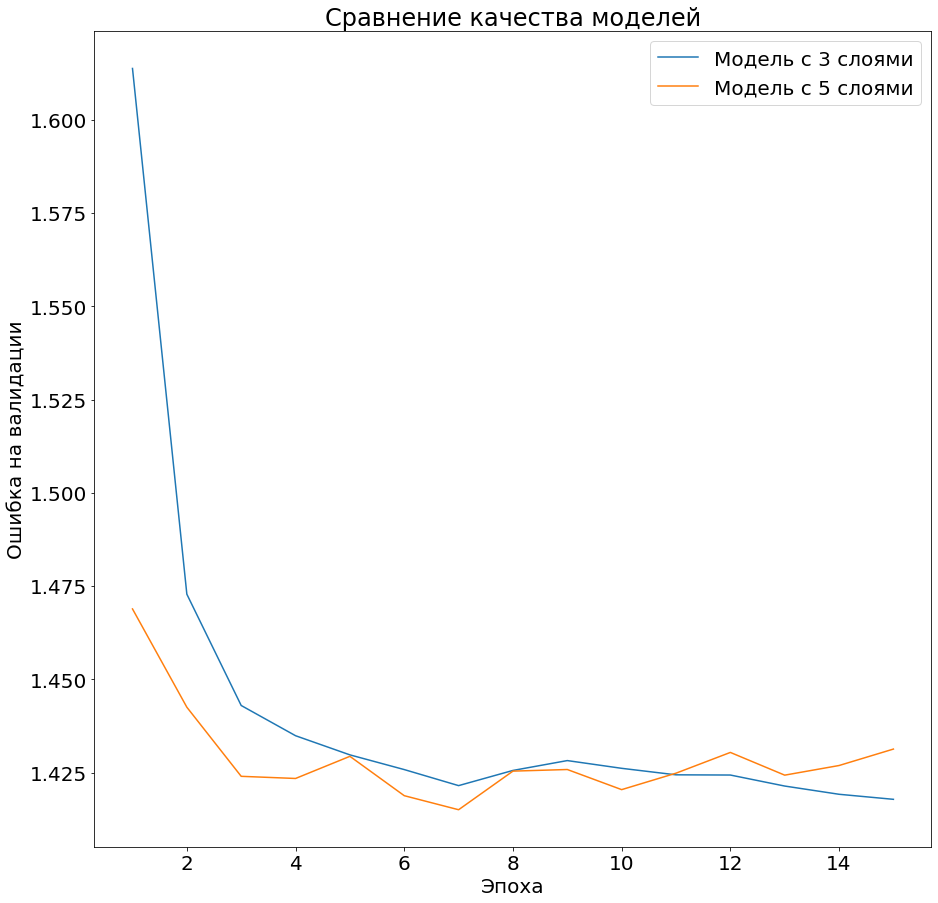

In [323]:
plt.figure(figsize=(15,15))
plt.rcParams["font.size"]= 20
for key in dct_loss:
    arr = np.array(dct_loss[key])
    ln = len(arr[:,0])
    plt.plot(range(1,ln+1),arr[0:,1], label=f"Модель с {str(key)} слоями")
    plt.legend()
    
plt.title("Сравнение качества моделей")
plt.xlabel("Эпоха")
_=plt.ylabel("Ошибка на валидации")

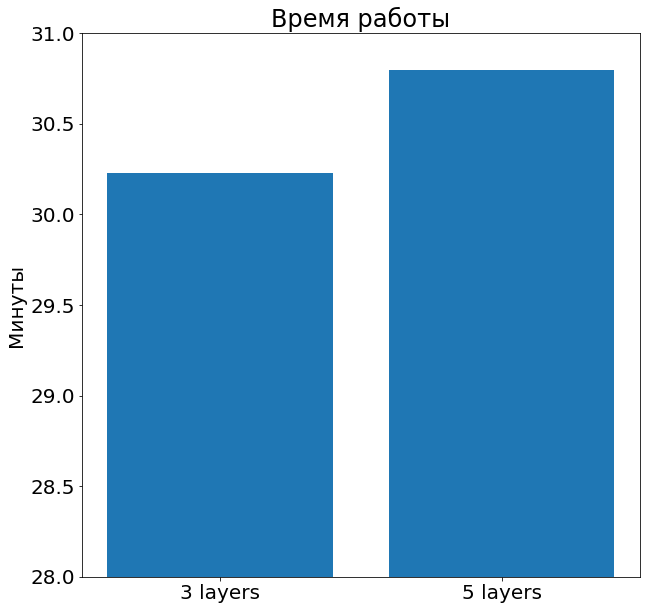

In [316]:
plt.figure(figsize=(10,10))
plt.bar(["3 layers","5 layers"],np.array(list(dct_time.values()))/60)
plt.ylim((28,31))
plt.title("Время работы")
_=plt.ylabel("Минуты")

**Выводы**
1. Пятислойная модель быстрее достигает сходимости, но за счет переобучения!
2. Трехслойная модель показывает достойное качество.
3. Время работы примерно одинаковое

Возможные причины переобучения: 
1. Слишком много параметров у пятислойной модели. 
2. Отсутствие регуляризации

В дальнейшем будем использовать более 3 слоев. С переобучением будем бороться регуляризацией.


# Техническое совешенствование

**Дальнейшая модификация модели** \
Существует два пути совершенствования модели:
1. Техническое совершенствование архитектуры (добавление batch_normalization, drop_out, skip_connections)
2. Идейное совершенствование:\
    а. Добавление GMF Layer,  учитывающее отношение (пользователь, предмет). \
    б. Учет ближайших пользователей, ближайших товаров. 

Начнем с технических модификаций, затем перейдем к идейному совершенствованию.


**Добавление batch_norm, drop_out, skip_connections**

In [413]:
class NNBlock(nn.Module):
    def __init__(self,in_features, out_features, fn_act=nn.GELU, batch_norm=False,p_drop_out=0.3):
        super().__init__()
        self.out_features = out_features
        
        self.linear1 = nn.Linear(in_features, out_features)
        self.act = fn_act()
        self.batch_norm = nn.BatchNorm1d(out_features) if batch_norm else nn.Identity()
        self.drop = nn.Dropout(p_drop_out) 
        
        
    def forward(self,x):
        out = self.linear1(x)
        out = self.act(out)
        out = self.batch_norm(out)        
        out = self.drop(out)
        return out
        

In [319]:
class Skip_module(nn.Module):
    def __init__(self,in_features, out_features,fn_act=nn.ReLU):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.act = fn_act()
        
        
    def forward(self,x):
        out = self.linear(x)
        return self.act(out)

In [338]:
class MLP(nn.Module):
    def __init__(self,amount_layers=3,q_users=q_users,q_items=q_items,fn_act=nn.ReLU,
                 latent_factors=8, base_multiply=2, p_dropout=0.,batch_norm=False, skip=False):
        super().__init__()
        self.q_users = q_users
        self.q_items = q_items
        # слои создают скрытые представления пользователя и предмета
        self.emb_user = nn.Linear(q_users, latent_factors)
        self.emb_item = nn.Linear(q_items, latent_factors)
        lt_f = latent_factors
        self.skip_indicator = 1. if skip else 0.
        
        self.block1 = NNBlock(lt_f*2, lt_f*2*base_multiply,fn_act, batch_norm, p_dropout)
        
        self.block2 = NNBlock(self.block1.out_features, self.block1.out_features*base_multiply,
                               fn_act, batch_norm, p_dropout)
        
        self.block3 = NNBlock(self.block2.out_features, self.block2.out_features*base_multiply,
                               fn_act, batch_norm, p_dropout) if amount_layers > 3 else nn.Identity()
        
        self.block4 = NNBlock(self.block3.out_features, self.block3.out_features*base_multiply,
                               fn_act, batch_norm, p_dropout) if amount_layers > 4 else nn.Identity()
        
        self.end_linear = nn.Linear(lt_f*2*(base_multiply**(amount_layers-1)),1)
        
        self.skip_concat_to_block4 = Skip_module(lt_f*2,self.block3.out_features)
        
    

    def forward(self,x_u,x_i):
        
        #формируем бинарные векторы для пользователя и предмета
        bt_size = len(x[0])
        us_bin = torch.zeros(bt_size,self.q_users)
        it_bin = torch.zeros(bt_size, self.q_items)
        us_bin[range(bt_size), x[0]] = 1
        it_bin[range(bt_size), x[1]] = 1
        
        # получаем эмбеддинги
        emb_us = self.emb_user(us_bin.float())
        emb_it = self.emb_item(it_bin.float())
        
        concat_vec = torch.concat((emb_us, emb_it),dim=1)
        
        out1 = self.block1(concat_vec) # 32 при основании 2
        out2 = self.block2(out1) # 64
        out3 = self.block3(out2) + self.skip_concat_to_block4(concat_vec) *self.skip_indicator # 128
        out4 = self.block4(out3) # 256
        out5 = self.end_linear(out4) 
        
        return out5

In [339]:
def validate(model,train_dataloader, val_dataloader, n_epochs=5):
    loss_fn = nn.MSELoss()
     
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    lst_err = []
    start_time = time.time()
    for epoch in tqdm.tqdm(range(n_epochs)):
        train_loss = perform_epoch(model,train_dataloader,loss_fn,optimizer,)
        val_loss = perform_epoch(model,val_dataloader,loss_fn,None)
        lst_err.append([np.sqrt(train_loss), np.sqrt(val_loss)])



    finish_time = time.time()
    spent_time = finish_time - start_time
        
    return lst_err, spent_time

In [373]:
train_dataset = Dataset(df)
val_dataset = Dataset(val_df)

train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=512,drop_last=True,shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=1024)

In [385]:
def draw_first(arr,alone=True,label="",title="Ошибка на валидации"):
    plt.figure(figsize=(15,15))
    plt.rcParams["font.size"]= 20
    ln = len(arr)
    plt.plot(range(1,ln+1),arr, label=label)
    plt.title(title)
    plt.xlabel("Эпоха")
    _=plt.ylabel("Ошибка на валидации")

**Стоит ли добавлять skip connection**

100%|██████████| 5/5 [10:28<00:00, 125.60s/it]


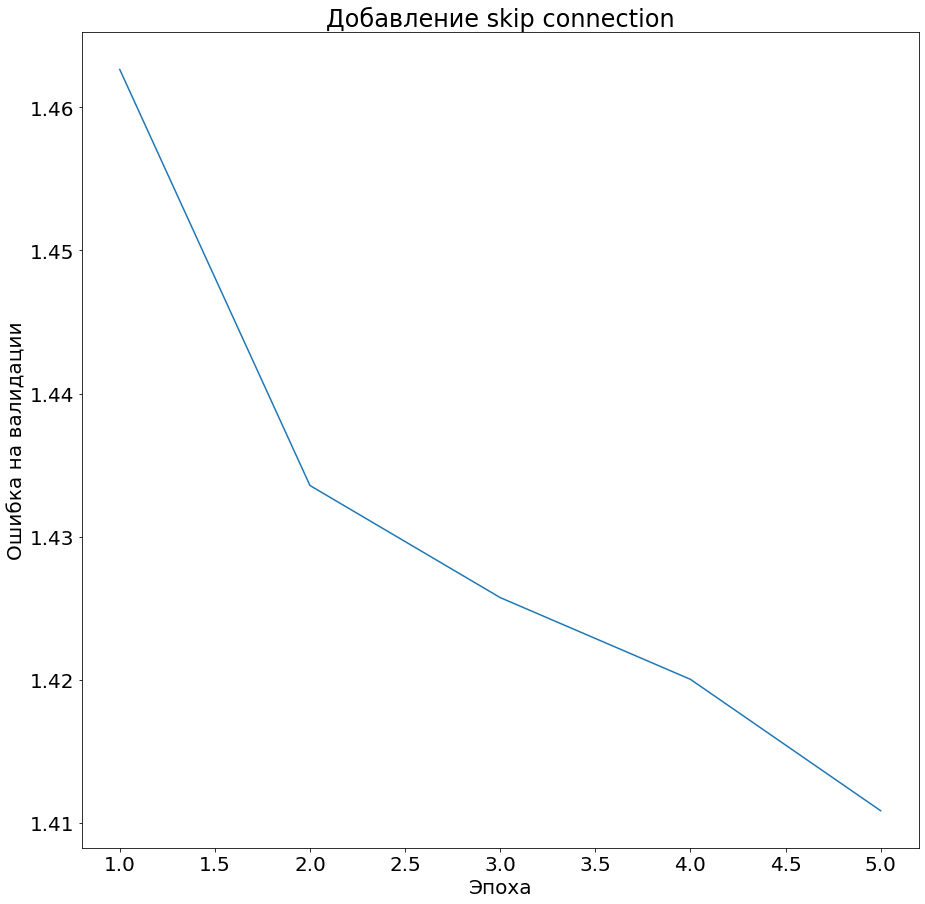

In [376]:
model = MLP(amount_layers=5, fn_act=nn.GELU,
                latent_factors=8, p_dropout=0.,batch_norm=False, skip=True)
errors, spent_time = validate(model,train_dataloader,val_dataloader,n_epochs=5)
plt.figure(figsize=(15,15))
plt.rcParams["font.size"]= 20
draw_first(np.array(errors)[:,1],title="Добавление skip connection")

**Skip connection дал  прирост в качестве и более гладкую сходимость. Будем использовать.**

**Исследуем качество модели в зависимости от присутствия batch_norm.**

In [380]:
dct_bn = {}
for bn in (False,True):
    model = MLP(amount_layers=5, fn_act=nn.GELU,
                latent_factors=8, p_dropout=0.,batch_norm=bn, skip=True)
    errors, spent_time = validate(model,train_dataloader,val_dataloader,n_epochs=6)
    dct_bn[bn] = errors

100%|██████████| 6/6 [12:40<00:00, 126.79s/it]


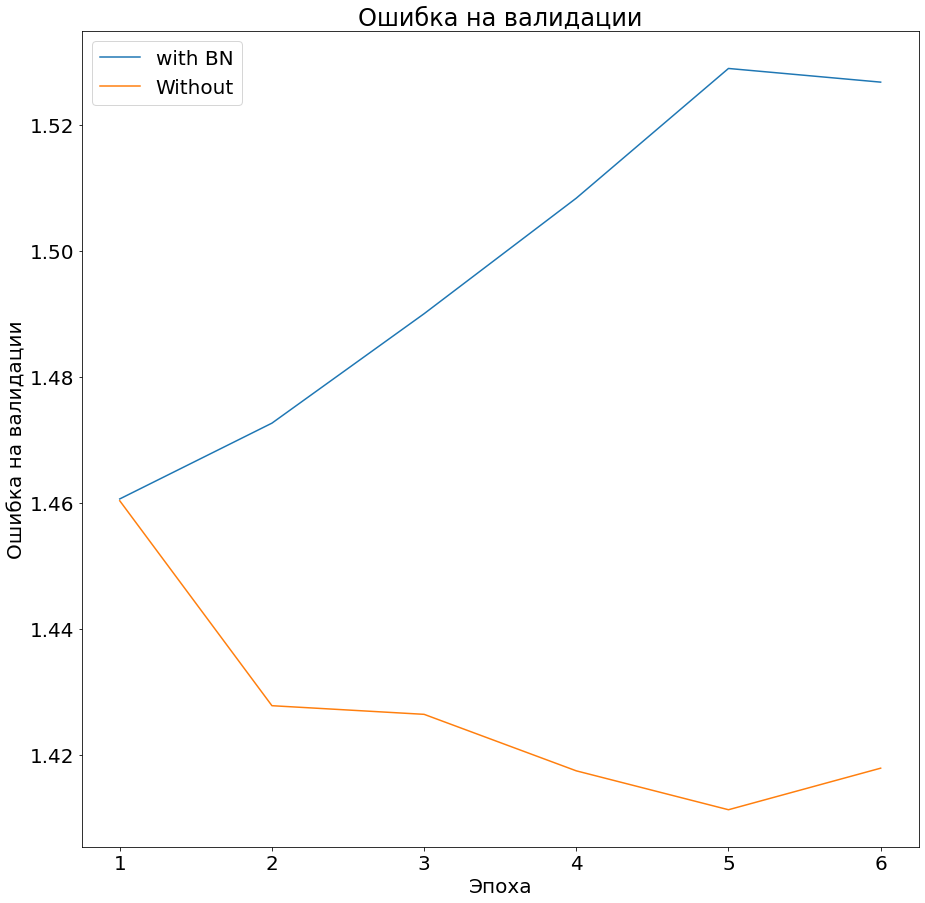

In [383]:
plt.figure(figsize=(15,15))
plt.rcParams["font.size"]= 20
draw_first(np.array(dct_bn[True])[:,1], "Влияние batch_norm на качество модели",label="with BN")
er = np.array(dct_bn[False])[:,1]
plt.plot(range(1,len(er)+1),er, label="Without")
plt.legend()

**BN использовать не будем.**

**Исследуем влияние Drop Out.**

In [384]:
dct_p = {}
for p in (0.05,0.1,0.2,0.3):
    model = MLP(amount_layers=5, fn_act=nn.GELU,
                latent_factors=8, p_dropout=p, batch_norm=False, skip=True)
    errors, spent_time = validate(model, train_dataloader, val_dataloader, n_epochs=7)
    dct_p[p] = errors

100%|██████████| 7/7 [15:37<00:00, 133.94s/it]


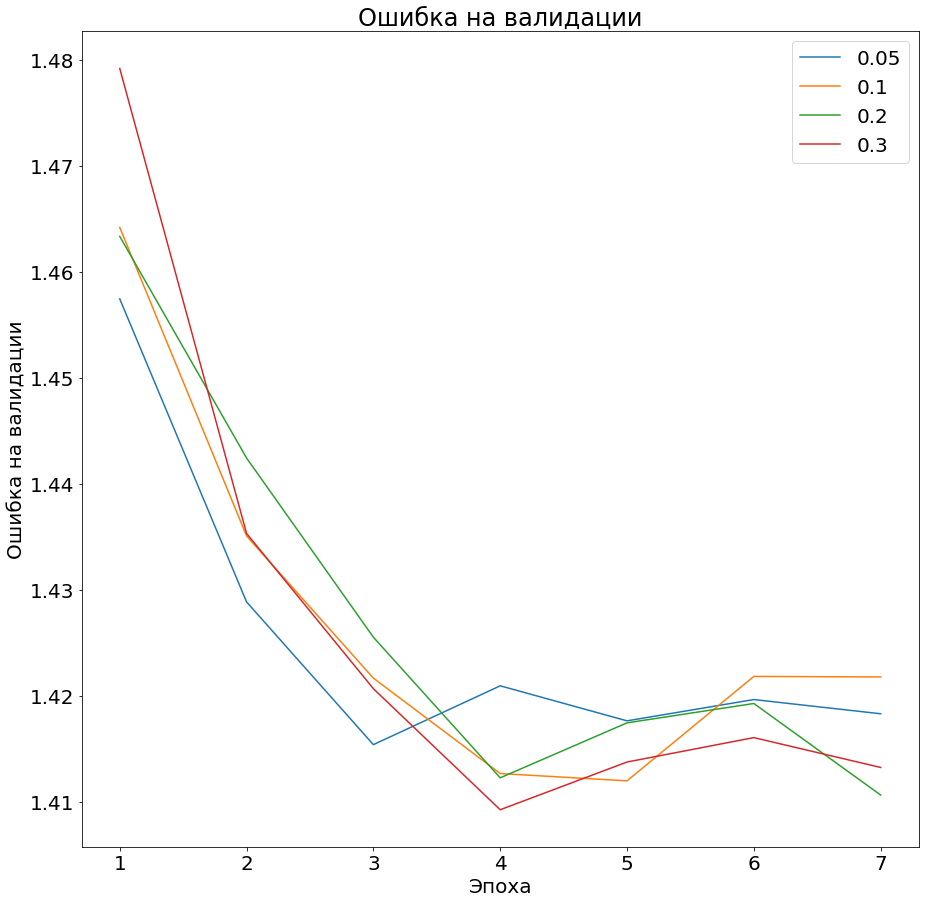

In [387]:
draw_first(np.array(dct_p[0.05])[:,1], "Влияние Drop Out на качество модели",label=f"{0.05}")
for p in [0.1,0.2,0.3]:
    er = np.array(dct_p[p])[:,1]
    plt.plot(range(1,len(er)+1),er, label=f"{p}")
plt.legend()

**Drop Out добавляет робастность, избавляет от излишнего переобучения. В дальнейшем будем использовать.**

# Идейное совершенствование
# Добавление блока GMF.

**Внесем изменения в  блок MLP. Теперь на вход подаются  эмбеддинги. Последний слой, предсказывающий таргет, удалим. Останется 4 слоя.**

In [461]:
class MLP_up(nn.Module):
    def __init__(self,latent_factors=8,amount_layers=4,fn_act=nn.GELU, base_multiply=2, p_dropout=0.3,batch_norm=False, skip=True):
        super().__init__()

 

        lt_f = latent_factors
        self.skip_indicator = 1. if skip else 0.
        
        self.block1 = NNBlock(lt_f*2, lt_f*2*base_multiply,fn_act, batch_norm, p_dropout)
        
        self.block2 = NNBlock(self.block1.out_features, self.block1.out_features*base_multiply,
                               fn_act, batch_norm, p_dropout)
        
        self.block3 = NNBlock(self.block2.out_features, self.block2.out_features*base_multiply,
                               fn_act, batch_norm, p_dropout) if amount_layers > 2 else nn.Identity()
        
        self.block4 = NNBlock(self.block3.out_features, self.block3.out_features*2,
                               fn_act, batch_norm, p_dropout) if amount_layers > 3 else nn.Identity()
        
        self.out_features = lt_f*2*(base_multiply**amount_layers)
        

        
        self.skip_concat_to_block4 = Skip_module(lt_f*2,self.block3.out_features)
        
    

    def forward(self,emb_us, emb_it):

        
        concat_vec = torch.concat((emb_us, emb_it),dim=1)
        
        out1 = self.block1(concat_vec) # 32 при основании 2
        out2 = self.block2(out1) # 64
        out3 = self.block3(out2) + self.skip_concat_to_block4(concat_vec) *self.skip_indicator # 128
        out4 = self.block4(out3) # 256

        
        return out4

In [460]:
class GMF(nn.Module):
    def __init__(self, latent_factors=8,out_features=32,fn_act=nn.GELU, # out_features увеличили в два раза
                  base_multiply=2, p_dropout=0.3,batch_norm=False, skip=True):
        super().__init__()
        self.out_features = out_features 
        self.latent_factors = latent_factors
        self.block1 = NNBlock(self.latent_factors, self.latent_factors*2,fn_act=nn.GELU, batch_norm=False,p_drop_out=p_dropout)
        self.block2 = NNBlock(self.latent_factors*2,out_features,fn_act=nn.GELU, batch_norm=False,p_drop_out=p_dropout) # 32

    def forward(self,emb_us, emb_it):
        x = emb_us * emb_it # point-wise multiplying
        out = self.block1(x)
        out = self.block2(out)
        
        return out
        
        
        

In [462]:
class NCF(nn.Module):
    def __init__(self,latent_factors=8, q_users=q_users, q_items=q_items):
        super().__init__()
        self.q_users = q_users
        self.q_items = q_items
        self.latent_factors = latent_factors
        
        # слои создают скрытые представления пользователя и предмета
        self.emb_user = nn.Linear(q_users, latent_factors)
        self.emb_item = nn.Linear(q_items, latent_factors)
        
        self.MLPblock = MLP_up()
        self.GMFblock = GMF()
        
        # слой, формирующий конечное предсказание
        self.last_layer = nn.Linear(self.GMFblock.out_features + self.MLPblock.out_features, 1)
        
    def embedding(self,x):
        
        #формируем бинарные векторы для пользователя и предмета
        bt_size = len(x[0])
        us_bin = torch.zeros(bt_size,self.q_users)
        it_bin = torch.zeros(bt_size, self.q_items)
        us_bin[range(bt_size), x[0]] = 1
        it_bin[range(bt_size), x[1]] = 1
        
        # получаем эмбеддинги
        emb_us = self.emb_user(us_bin.float())
        emb_it = self.emb_item(it_bin.float())
        
        return emb_us, emb_it 
    
    def forward(self,x):
        
        emb_us, emb_it = self.embedding(x)
        
        mlp_res = self.MLPblock(emb_us, emb_it) # 256
        gmf_res = self.GMFblock(emb_us, emb_it) # 32
        
        concat_vec = torch.concat((mlp_res, gmf_res),dim=1) # 256 + 32
        
        out = self.last_layer(concat_vec)
        
        return out
        
        
        
        
        
        
        
        
        
        
        
        

In [441]:
train_dataset = Dataset(df)
val_dataset = Dataset(val_df)

train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=512,drop_last=True,shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=1024)

In [432]:
model = NCF()
errors, spent_time = validate(model, train_dataloader, val_dataloader, n_epochs=15)

100%|██████████| 15/15 [31:42<00:00, 126.84s/it]


In [448]:
min(np.array(errors)[:,1]) # достигнутое качество на валидационном датасете

1.3995053865138958

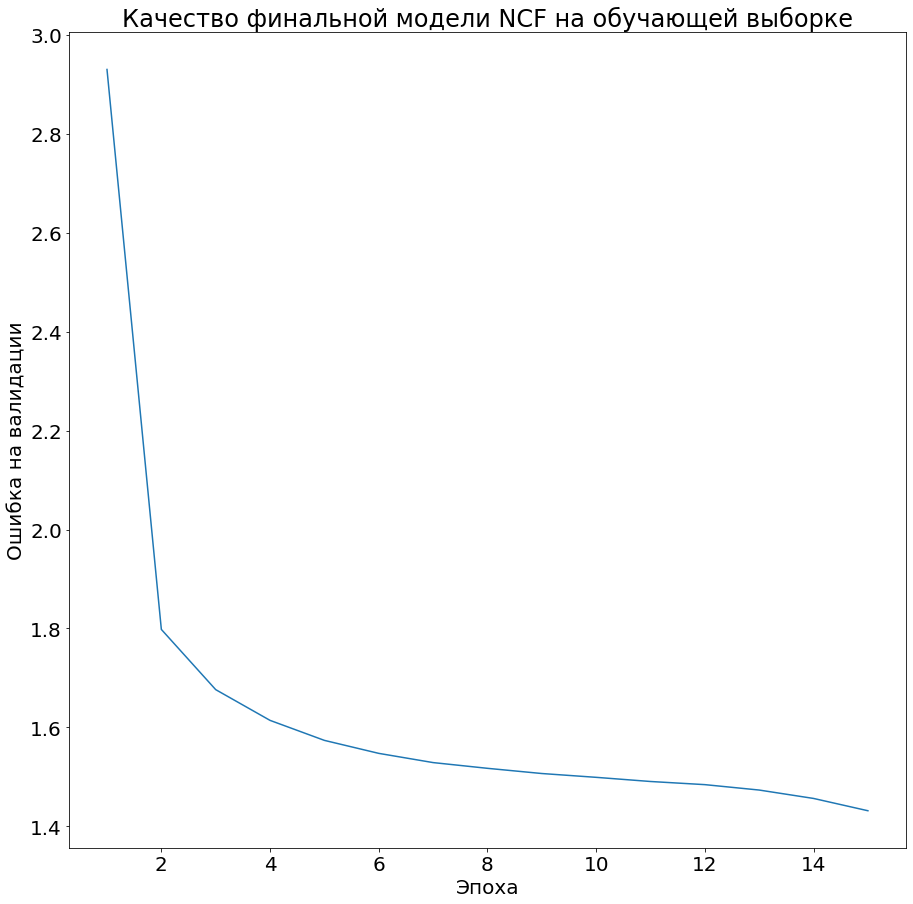

In [465]:
draw_first(np.array(errors)[:,0], title="Качество финальной модели NCF на обучающей выборке")

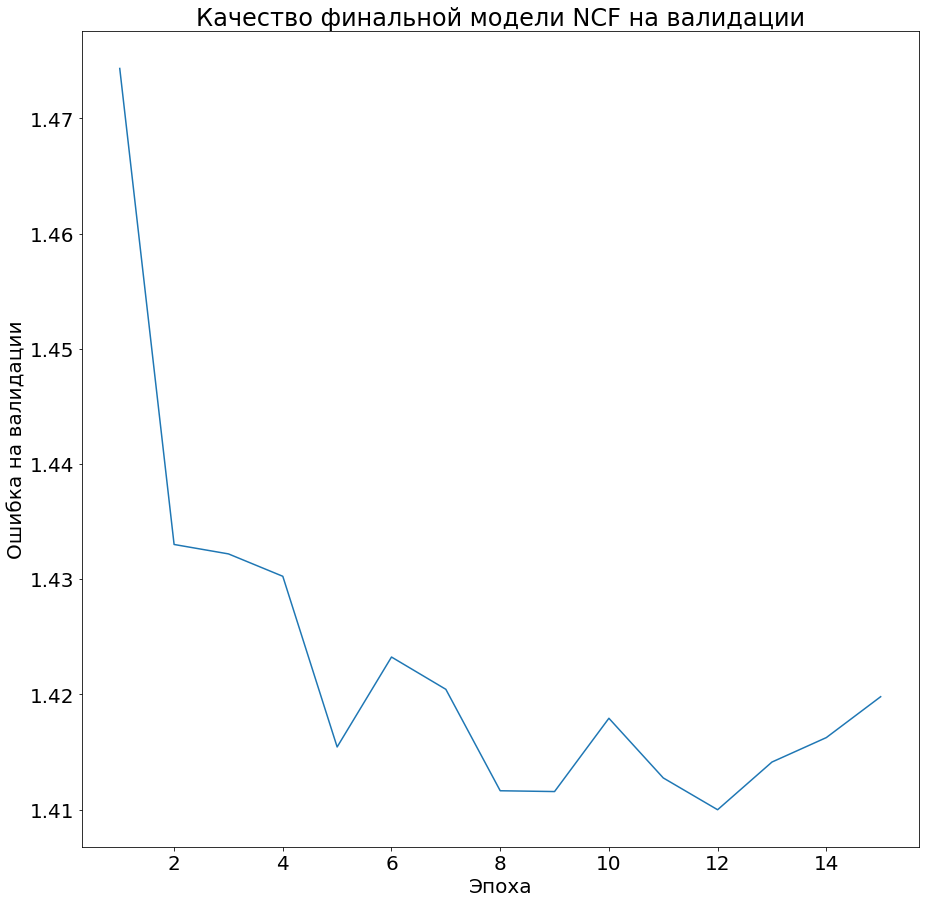

In [469]:
draw_first(np.array(errors)[:,1], title="Качество финальной модели NCF на валидации")

# Выводы и дальнейшие предложения

В данной работе была сконструирована собственная Neural CF. Было достигнуто качество RMSE 1.399 на валидации, что превышает аналогичные показатели, посчитанные для первоначальных моделей.



В дальнейшем можно добавить **блоки, учитывающие ближайших пользователей, ближайшие товары**. Для этого необходимо для каждого пользователя/предмета получить его скрытое представление с помощью нашего слоя emb_user, emb_item. Затем над полученным признаковым пространством запустить KNN. Получим индексы k ближайших соседей. Блоки будут состоять из одного линейного слоя (так как и без того перебучение) и принимать на вход бинарные векторы, которые учитывают ближайших соседей/предметов. Бинарный  вектор состоит из нулей и единиц. Единицы стоят на тех позициях, которые отвечают за конкретных пользователей (в нашем случае ближайших). Таким образом, на вход линейному слою придет сумма скрытых представлений ближайших пользователей/предметов. 

Преимущество подхода заключается в том, что кроме того чтобы смотреть только на пару (пользователь,предмет), мы будем учитывать также и и ближайшее соседство пользователя и предмета. Ожидается, что эта модификация увеличит качество модели.**


В качестве **исследовательской задачи** можно сравнить окрестоности, посчитанные с помощью слоя emb_user, emb_item, и окрестиности посчитанные KNNBasic на основе косинусной метрики. Затем с помощью валидации выбрать лучший алгоритм построения окрестности. 

**Недостаток данного подхода** заключается в том, что добавится latent_factors * num_user + latent_factors * num_items параметров. В нашем случае добавится 8 * (104563 + 7519) = 896 656 новых параметров (!), и сетка и без того страдающая от **переобучения будет к нему еще более склонна**. Вместо этого предлагается **кластеризовать пользователей и предметы**. Реализация повторяет предыдущее, но вместо того, чтобы для каждого пользователя/предмета искать ближайших соседей, будем искать ближайший кластер. Поскольку количество кластеров будет невелико, то и влияние, оказываемое на переобучение, будет многократно ниже. Например,  если выбрать количество кластеров 5 для пользователей и предметов, получим [размер выходного вектора линейного слоя * (5 + 5)] в нашем случае. При разумной нулевой размерности  матрицы линейного слоя это цифра будет на порядки меньше, чем 896 656. 


Количество кластеров для пользователей и для предметов может быть различным и может исходить из понимания контекста исследовательской задачи. Например, в случае предсказания оценки фильма, количество кластеров фильмов может быть посчитано, исходя из примерного количества главных жанров кино. Количество групп пользователей может быть расчитано, исходя из исследований половозрастной структуры потребителей, мощности фактор-множества их основных предпочтений или иных социальных характеристик. Здесь может помочь уже глубинное исследование потребителей  сервиса, если бы мы решали реальную задачу.

Чтобы уменьшить количество параметрво модели, можно в качестве эмбеддингов выбрать вектора p_u, q_i, полученные SVD разложением. 





Из вышеперечисленного я пробовал следующее. Я построил кластеры на основе матрицы emb_user, emb_item и затем добавил номер кластера для каждого пользователя/предмета в качестве признака. А вместо матрицы emb_user, emb_item добавил латентные представления предмета и пользователя из разложения SVD с целью уменьшения количества параметров. Однако на валидации прироста качества не достиг. 